# Purchase Order Item Categorization Challenge

In [87]:
# ==============================================================================
# SETUP: IMPORTING LIBRARIES
# ==============================================================================
# We'll start by importing the essential libraries for data manipulation, 
# visualization and other tasks as well. 

import pandas as pd  
import numpy as np   
import matplotlib.pyplot as plt 
import seaborn as sns 
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

import re
# Set some visual styles for our plots to make them more readable.
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

c:\Users\yaman\anaconda3\envs\POProject\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ==============================================================================
# Data Understanding
# ==============================================================================
# The following steps will be dedicted to understand the data to make the 
# data processing step as effective as possible. 
# EDA

df = pd.read_excel(r"C:\Users\yaman\Desktop\Personal Projects\PO Item Categorization Challenge\purchase-order-items.xlsx") # Load data to be read
display(df.head()) # Display the first 5 raws, just to understand generally how the data looks like
print("\n") # Space for better visibility
display(df.info()) # Let us understand more about the numerics (null instances, total rows, etc...)
print("\n") # Space for better visibility
# Let us focus on null values
missing_values = df.isnull().sum() # Calculate the number of missing values in each column.
if missing_values.empty: # If we have NO null-values
    print("Great! No missing values found in the dataset.")
else:
    print("Missing values found in the following columns:")
    missing_percentage = (missing_values / len(df)) * 100  # Calculate the percentage of missing values.
    missing_info = pd.DataFrame({'Missing Count': missing_values, 'Percentage (%)': missing_percentage}) # Put them as a data frame for the sake of sorting values by percentages
    print(missing_info.sort_values(by='Percentage (%)', ascending=False))




,Item ID,Item Name,Quantity,Total Bcy,Sub Total Bcy,Purchase Order ID,Product ID,Currency Code,Account ID,Tax ID,Project ID
0,3263831000000089042,NaN,75.21,227510.25,227510.25,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
1,3263831000000089046,NaN,15.00,47250.00,47250.00,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
2,3263831000000089044,NaN,50.00,160000.00,160000.00,3263831000000089040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
3,3263831000000092044,NaN,12.00,38280.00,38280.00,3263831000000092040,NaN,SAR,3263831000000034003,3.263831e+18,NaN
4,3263831000000092052,NaN,2.00,5900.00,5900.00,3263831000000092040,NaN,SAR,3263831000000034003,3.263831e+18,NaN




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item ID            3150 non-null   int64  
 1   Item Name          2910 non-null   object 
 2   Quantity           3150 non-null   float64
 3   Total Bcy          3150 non-null   float64
 4   Sub Total Bcy      3150 non-null   float64
 5   Purchase Order ID  3150 non-null   int64  
 6   Product ID         2910 non-null   float64
 7   Currency Code      3150 non-null   object 
 8   Account ID         3150 non-null   int64  
 9   Tax ID             3085 non-null   float64
 10  Project ID         0 non-null      float64
dtypes: float64(6), int64(3), object(2)
memory usage: 270.8+ KB


None



Missing values found in the following columns:
                   Missing Count  Percentage (%)
Project ID                  3150      100.000000
Item Name                    240        7.619048
Product ID                   240        7.619048
Tax ID                        65        2.063492
Item ID                        0        0.000000
Quantity                       0        0.000000
Total Bcy                      0        0.000000
Sub Total Bcy                  0        0.000000
Purchase Order ID              0        0.000000
Currency Code                  0        0.000000
Account ID                     0        0.000000


- Verbally, we can see that there are 11 features (columns) in our data frame, with total of 3150 instances (rows). a decent number to a certain extent. 

- Context understanding: 

    * A PO with count as a single purchasing process that can include mutiple items. This suggests that maybe one thing that we can do here is to look for highest POs in terms of the spending (look for unique values and then calculating the sum) which helps see highest categories sold.
    * I'm assuming that Item IDs are unique and do not change for the same item from one PO to another. One step that we will try is to recover missing Item Names using those if they exist in a different PO with their Item IDs. WHY? This is for us to be able to have a better conclusion afterwards on which items 
    * Bcy? I did not really understand this. So, instead of making a random assumption, I asked ChatGPT to suggest based on its knowledge, which it suggested to be (the total purchase value converted into the organization’s base (reporting) currency).
    * Total Bcy and Sub Total Bcy look to have the same content. I want to check if they are the same to remove one. Currently, I'm assuming they are different.
    * I believe the current item names help us in creating a categorization for further processing and reporting tasks, let us explore this option as well before doing so
    * I can see that currency needs to be unified
    * I see that some columns like Account ID always have the same value, which suggests that we need to remove


- <span style="color: red;">Targeted workflow</span>
    * <span style="color: LightBlue;">Data Context Understanding</span> ✅
    * <span style="color: LightBlue;">Data Cleaning and Processing</span>
    * <span style="color: LightBlue;">Implementation (Data Analysis and Model Developement)</span>
    * <span style="color: LightBlue;">Results and Discussions</span>
    * <span style="color: LightBlue;">Conclusion</span>

- Initial steps to be taken --> 
    * It is evident that project ID must be eleminated as it has 100% null values. 
    * Try to recover missing Item names
    * If previous approach does not work. Remove null values
    * Look at the different instances in the "Item Name" feature to see if we can replace it with a better high level categories
    * Eleminate unneeded features like Project ID and Account ID and others as well

In [53]:
# Data Cleaning --> Remove Project ID
df1 = df.copy() # Make a copy just in case we need to come back to the original version
df1.drop("Project ID", inplace=True, axis=1) # Remove Project ID as it adds to value (100% null value)

In [54]:
# Data Cleaning --> Try to recover item names

# In the following line, groups based on "Product IDs" and then from transform, we are bringing the
# first non null value from Item name in that group. Why? If I get something there, I know that we have
# Some instances that we can recover. Otherwise (in case if None), we know that this step 
# is not possible


nullMask = df1['Item Name'].isna() # I want to focus on null values (anything that haa values are irrelevant)
dfNull = df1[nullMask] # Only null values are here (based on Item Names)

df_named = df1.dropna(subset=['Item Name']) # In this instance, we are keeping the non null values, WHY?
                                            # This is the df where we will seek the Product ID for the present Item Names

name_counts = df_named.groupby('Item ID')['Item Name'].nunique() # Count instances of Item Name based on Product IDs
unique_one_ids = name_counts[name_counts == 1].index # Get Only the unique Product ID value? WHY???
# If the code above does NOT show unique Product IDs, this contradicts my initial assumption

# The following is AI generated to facilitate the mapping and reporting process of this
# experiment

single_name_map = ( # Create the mapping (the null Item name will now have the a name for the same Prodcut ID)
    df_named
      .drop_duplicates(subset=['Item ID','Item Name'])
      .set_index('Item ID')['Item Name']
      .loc[unique_one_ids]
)

# 3) For the null rows, see which are recoverable from the map
df_null_report = dfNull.assign(Proposed_Name=dfNull['Item ID'].map(single_name_map))
recoverable = df_null_report['Proposed_Name'].notna()

# --- Reporting ---
total_null = len(df_null_report)
can_recover = int(recoverable.sum())

print(f"Null Item Name rows: {total_null}")
print(f"Recoverable (same Product ID has a single known name elsewhere): {can_recover}")

print("\nExamples (up to 10):")
print(
    df_null_report.loc[recoverable, ['Item ID', 'Item Name', 'Proposed_Name']]
                   .drop_duplicates('Item ID')
                   .head(10)
                   .to_string(index=False)
)

Null Item Name rows: 240
Recoverable (same Product ID has a single known name elsewhere): 0

Examples (up to 10):
Empty DataFrame
Columns: [Item ID, Item Name, Proposed_Name]
Index: []


# <span style="color: SkyBlue;">Checkpoint</span>

We can conculde that it is a bit difficult to recover this information. Hence and instead of adding some random names and product IDs, I will go with removing ALL null instances.


<span style="color: red;">I have committed a mistake and now I want to correct it, before removing null values, I will remove the unneeded features and then remove null values. WHY? Cause when I removed the null values, the rows with missing tax IDs got removed. Those are in USD and therefore it is only natural for them not to have such. These rows have full information apart from tax ID. (Tax ID has only 1 value and therefore I will romove it)</span>


In [55]:
# Data Cleaning, remove all null instances

features = df1.columns # All features here
for i in features: 
    print(f"The number of values present in this feature ({i}) is: {(df1[i].nunique())}")

print(df1["Currency Code"].unique()) # Print the unique values in each feature.
# I can sense that we need to remove the tax ID feature. I will test if (Total Bcy) and
# (Sub Total Bcy) have the same value, if so, one will be removed. All values in totals will
# be unified in SAR and then remove the currency code

The number of values present in this feature (Item ID) is: 3150
The number of values present in this feature (Item Name) is: 2302
The number of values present in this feature (Quantity) is: 441
The number of values present in this feature (Total Bcy) is: 2246
The number of values present in this feature (Sub Total Bcy) is: 2246
The number of values present in this feature (Purchase Order ID) is: 531
The number of values present in this feature (Product ID) is: 896
The number of values present in this feature (Currency Code) is: 2
The number of values present in this feature (Account ID) is: 2
The number of values present in this feature (Tax ID) is: 1
['SAR' 'USD']


In [64]:
# Check if we can eleminate some unneeded features
(df1["Sub Total Bcy"] == df1["Total Bcy"]).value_counts() # This shows that they are not the same and 
# hence we cannot remove one of them
# Assumeing 3.75 exchange rate from SAR to USD
df1.loc[df1["Currency Code"] == "USD", "Total Bcy"] = df1["Total Bcy"] * 3.75 # Any USD will be converted to SAR
df1.loc[df1["Currency Code"] == "USD", "Sub Total Bcy"] = df1["Sub Total Bcy"] * 3.75 # Any USD will be converted to SAR
display(df1["Account ID"].value_counts()) # This one tells you that there is only 1 instance differet from the dominent one. Hence, I will remove the account ID feature
print()
df1.drop(["Tax ID", "Currency Code", "Account ID"], inplace=True, axis=1) # Drop Tax, Account ID and Currency Code


Account ID
3263831000000034003    3149
3263831000000000409       1
Name: count, dtype: int64

In [68]:
# Drop the Null values NOW
# df1.info()
df1.dropna(inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2910 entries, 233 to 3149
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item ID            2910 non-null   int64  
 1   Item Name          2910 non-null   object 
 2   Quantity           2910 non-null   float64
 3   Total Bcy          2910 non-null   float64
 4   Sub Total Bcy      2910 non-null   float64
 5   Purchase Order ID  2910 non-null   int64  
 6   Product ID         2910 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 181.9+ KB


# <span style="color: SkyBlue;">Checkpoint</span>

- Initial steps to be taken --> 
    * It is evident that project ID must be eleminated as it has 100% null values. ✅
    * Try to recover missing Item names ✅
    * If previous approach does not work. Remove null values ✅
    * Look at the different instances in the "Item Name" feature to see if we can replace it with a better high level categories ✅
    * Eleminate unneeded features like Project ID and Account ID and others as well ✅

    - <span style="color: red;">Targeted workflow</span>
    * <span style="color: LightBlue;">Data Context Understanding</span> ✅
    * <span style="color: LightBlue;">Data Cleaning and Processing</span> Soon...
    * <span style="color: LightBlue;">Implementation (Data Analysis and Model Developement)</span>
    * <span style="color: LightBlue;">Results and Discussions</span>
    * <span style="color: LightBlue;">Conclusion</span>



Now that we are done with the cleaning and almost done with the processing. We now go to make categories, which I believe will be the last data processing step in our case.

Based on my research and extensive chats with ChatGPT, I had the following ideas to deal with the category making: 
1. Translate Arabic names to English names and then try to do come up with categorization through TF-IDF or embeddings ❌ --> WHY? Because the item names are a bit random and translation in this case would damage the result in my opinion
2. Label part of the data manually and then train a Language Model or a basic classification model to do classify the rest ❌ --> WHY? This is probably a good approach and it may yield a really good result, but it will take major time to implement and test. 
3. Mine most frequent words to create basic high level classes. Then use embeddings and clustering to classify. ✅ Note that classification will take place on a PO level. Although this may affect the results negatively, it saves up the time and allows to deal with smaller (531) different value instead of more than 2000 different values. Also, one additional advatage of this approach is that the embeddings will capture both Arabic and English item names. This is huge risk if you ask me but let us see what can happen. 


In [70]:
# The following block of code was AI generated. It will do the words counting task

# Make all text lowercase, remove punctuation/numbers
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^ء-يa-z\s]', '', text)  # keep Arabic and English letters
    return text

# Apply cleaning
df1['clean_item'] = df1['Item Name'].apply(clean_text)

# Tokenize and count frequencies
all_words = " ".join(df1['clean_item']).split()
word_counts = Counter(all_words)

# Top 50 most frequent words
top_words = word_counts.most_common(50)
print(top_words)

[('mm', 738), ('حديد', 514), ('مم', 495), ('x', 383), ('تسليح', 310), ('f', 232), ('سابك', 202), ('م', 198), ('m', 197), ('bar', 179), ('ملم', 158), ('p', 149), ('متر', 147), ('deformed', 143), ('سماكة', 130), ('صاج', 125), ('straight', 122), ('black', 121), ('اسود', 116), ('unit', 106), ('w', 106), ('g', 97), ('ppr', 97), ('mtr', 96), ('اتفاق', 78), ('ماسورة', 73), ('steel', 68), ('pipe', 67), ('sheet', 66), ('مقاس', 64), ('سم', 64), ('بوصة', 62), ('hdg', 62), ('with', 62), ('hr', 60), ('a', 60), ('xtn', 59), ('cable', 57), ('ekip', 57), ('وطني', 55), ('سلك', 54), ('sabic', 53), ('سعودي', 50), ('rebar', 48), ('pvc', 48), ('طول', 47), ('و', 47), ('ملي', 46), ('lsi', 46), ('حدد', 46)]


The previous results are disappointing honestly. Let me try doing the same but on bi-grams

In [76]:
# The following block is also AI generated

# Assume df1['Item Name'] has your raw descriptions
texts = df1['Item Name'].fillna('').astype(str).str.lower()

# Keep Arabic + English letters/numbers only
token_pattern = r'(?u)\b[ء-يa-z0-9]+\b'

# Vectorizer for bi-grams
vectorizer = CountVectorizer(ngram_range=(2,2), token_pattern=token_pattern)
X = vectorizer.fit_transform(texts)

# Sum frequencies
freqs = X.sum(axis=0).A1
bigram_freq = pd.DataFrame({
    'bigram': vectorizer.get_feature_names_out(),
    'count': freqs
}).sort_values(by='count', ascending=False)

print(bigram_freq.head(60))  # top 30 bi-grams

                 bigram  count
5716         حديد تسليح    297
4571       straight bar    122
2661  deformed straight    122
2884                f f    112
25                 0 mm    111
2189     black deformed     92
3608           mm black     92
2112            bar g60     91
317                12 م     83
1142               3p f     82
5605         تسليح سابك     81
304                12 m     76
6046           صاج حديد     72
5602        تسليح اتفاق     71
6637           مم سماكة     64
81                  1 2     60
3029             g60 12     58
6617              مم 12     57
356           1220 2440     55
318              12 متر     52
1769               8 مم     50
100                 1 5     50
5711          حديد اسود     46
1392               5 mm     45
3599              mm 12     45
825             2440 مم     43
3485            m sabic     43
2808           ekip dip     41
5609         تسليح وطني     41
307              12 mtr     41
5719          حديد سابك     41
5084    

What can we do now? I can see that the text is affected by the noise (letters in random positions, measurement units in random positions, etc...). So, after taking a look at the output previously after using the bi-grams, I think what we can do here is to use the following classification: 

1. Rebar & Steel Bars
(e.g., حديد تسليح, rebar, bar g60, deformed, straight bar, steel bar, g60)

2. Steel Sheets / Plates
(e.g., صاج, sheet, plate, black/اسود, HR/CR, typical sheet sizes like 1220 2440, mm thick)

3. Pipes & Tubes
(e.g., ماسورة, pipe, ppr, pvc, gi, hdg)

4. Other / Specs / Unclassified
(dimensions, units, vendor-only terms like سابك when no product term appears)

In [81]:
# Let us do the mapping here

def clean_text(s: str) -> str: # This is the same code as above to clean the text\
    s = '' if pd.isna(s) else str(s).lower().strip()
    # keep Arabic letters, English letters/digits, and spaces
    s = re.sub(r'[^ء-يa-z0-9\s]+', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    return s

df1['item_clean'] = df1['Item Name'].apply(clean_text)

# Keyword sets (I mean those appear together. One possible case is to have several keywords
# from different classes but we will check them later on in the next function). Please note that
# this dict is AI generated
REBAR_KWS = [
    'حديد تسليح','rebar','bar g60','g60','deformed','straight bar',
    'steel bar','reinforcement','تسليح سابك','تسليح اتفاق','تسليح وطني'
]
SHEET_KWS = [
    'صاج','sheet','plate','hr','cr','black','اسود','coil','ملم','سماكة',
    'galv','galvanized','gi sheet','اسود 1220','1220 2440','mm thick'
]
PIPE_KWS = [
    'ماسورة','pipe','ppr','pvc','cpvc','hdpe','seamless','gi','hdg',
    'tube','conduit','duct','upvc','erw'
]

def has_kw(text, kws):
    return any(k in text for k in kws) # If we have this keyword in the item name tell us :)

# In this case, we are not doing multi-labeling. Why? Trying to target simplicity.
def classify_item(text: str) -> str:
    # Priority 1: Rebar & Steel Bars
    if has_kw(text, REBAR_KWS):
        return 'Rebar & Steel Bars'
    # Priority 2: Steel Sheets / Plates
    if has_kw(text, SHEET_KWS):
        return 'Steel Sheets / Plates'
    # Priority 3: Pipes & Tubes
    if has_kw(text, PIPE_KWS):
        return 'Pipes & Tubes'
    # Fallback
    return 'Other / Specs / Unclassified'

df1['Item_Class'] = df1['item_clean'].apply(classify_item)


print(df1['Item_Class'].value_counts()) # Quick look at distribution

Item_Class
Other / Specs / Unclassified    1457
Steel Sheets / Plates            606
Rebar & Steel Bars               513
Pipes & Tubes                    334
Name: count, dtype: int64


In [84]:
# Let us take a second look at the Other / Specs / Unclassified. 
#    display(df1.loc[df1["Item_Class"] == "Other / Specs / Unclassified",:].head(20))
# We can extract more I can see

# The following block is the same as above, mostly AI generated
other_df = df1[df1['Item_Class'] == "Other / Specs / Unclassified"] # Filter only rows that are classified as "Other / Specs / Unclassified"
texts = other_df['item_clean'].fillna('') 
X = vectorizer.fit_transform(texts)
freqs = X.sum(axis=0).A1
bigram_freq = pd.DataFrame({
    'bigram': vectorizer.get_feature_names_out(),
    'count': freqs
}).sort_values(by='count', ascending=False)

# 6) Show top 30 bigrams
print(bigram_freq.head(60))

                  bigram  count
1745                 f f    112
690                 3p f     81
1699            ekip dip     40
310              160 tmd     37
1961                i in     31
2126                ls i     30
1897                 h d     28
1588                 d g     28
1158                 a f     26
820                 4p f     26
1838                 g a     26
3216            xt2n 160     23
309              160 tma     22
1624              dip ls     22
42                   1 2     20
2989           unit each     19
2689           size none     19
2346          none color     19
3769         سلك السويدي     18
4052          لنموذج فلل     16
4299                 و د     16
3345   الالواح الخرسانية     16
3356  الخرسانية المعزولة     16
3395     المعزولة ثلاثية     16
1870          golde tech     15
1716           elie saab     15
1595           d3 لنموذج     14
3121          with cover     13
1406      cable trunking     13
2681  single compartment     13
1522    

In [85]:
# Let us do the mapping here. The second trial with the new classes added

def clean_text(s: str) -> str: # This is the same code as above to clean the text\
    s = '' if pd.isna(s) else str(s).lower().strip()
    # keep Arabic letters, English letters/digits, and spaces
    s = re.sub(r'[^ء-يa-z0-9\s]+', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    return s

df1['item_clean'] = df1['Item Name'].apply(clean_text)

# Keyword sets (I mean those appear together. One possible case is to have several keywords
# from different classes but we will check them later on in the next function). Please note that
# this dict is AI generated.
REBAR_KWS = [
    'حديد تسليح','rebar','bar g60','g60','deformed','straight bar',
    'steel bar','reinforcement','تسليح سابك','تسليح اتفاق','تسليح وطني'
]

SHEET_KWS = [
    'صاج','sheet','plate','hr','cr','black','اسود','coil','ملم','سماكة',
    'اسود 1220','1220 2440','mm thick'
    # removed 'galv','galvanized','gi sheet' (moved to Coatings)
]

PIPE_KWS = [
    'ماسورة','pipe','ppr','pvc','cpvc','hdpe','seamless',
    'tube','conduit','duct','upvc','erw'
    # removed 'gi','hdg' (moved to Coatings)
]

ELECTRICAL_KWS = [
    'cable','سلك','سويدي','trunking','tray','compartment','wire','wmp','3p'
    # removed 'clamp','tee' (moved to Fasteners)
]

CONCRETE_KWS = [
    'خرسانية','معزولة','panel','insulated','concrete'
]

FASTENER_KWS = [
    'clamp','tee','جلبة','bolt','nut','washer','stud','anchor','bracket','screw','fastener'
]

COATING_KWS = [
    'مجلفن','galv','galvanized','zinc','hot dip','gi','hdg','gi sheet'
]
def has_kw(text, kws):
    return any(k in text for k in kws) # If we have this keyword in the item name tell us :)

# In this case, we are not doing multi-labeling. Why? Trying to target simplicity.
def classify_item(text: str) -> str:
    # Priority 1: Rebar & Steel Bars
    if has_kw(text, REBAR_KWS):
        return 'Rebar & Steel Bars'
    # Priority 2: Steel Sheets / Plates
    if has_kw(text, SHEET_KWS):
        return 'Steel Sheets / Plates'
    # Priority 3: Pipes & Tubes
    if has_kw(text, PIPE_KWS):
        return 'Pipes & Tubes'
    if has_kw(text, ELECTRICAL_KWS):
        return 'Cables & Electrical'
    if has_kw(text, CONCRETE_KWS):
        return 'Concrete / Panels'
    if has_kw(text, FASTENER_KWS):
        return 'Fasteners & Accessories'
    if has_kw(text, COATING_KWS):
        return 'Coatings / Surface Treatment'
    # Fallback
    return 'Other / Specs / Unclassified'

df1['Item_Class'] = df1['item_clean'].apply(classify_item)


print(df1['Item_Class'].value_counts()) # Quick look at distribution


Item_Class
Other / Specs / Unclassified    1098
Steel Sheets / Plates            603
Rebar & Steel Bars               513
Pipes & Tubes                    288
Cables & Electrical              224
Fasteners & Accessories           99
Coatings / Surface Treatment      44
Concrete / Panels                 41
Name: count, dtype: int64


In [91]:
# Here, we will start embedding classification
# We start by defining the class and the prompts that corrospond to that class

CLASSES = {
    "Rebar & Steel Bars": [
        "rebar steel bar g60 deformed straight", 
        "حديد تسليح ج60 حديد تسليح مشوه",
        "reinforcement steel rebar"
    ],
    "Steel Sheets / Plates": [
        "steel sheet hot rolled cold rolled black plate",
        "صاج حديد صاج اسود لوح حديد",
        "steel plate sheet 1220 2440 mm thick"
    ],
    "Pipes & Tubes": [
        "steel pipe pvc ppr cpvc gi hdg tube conduit duct",
        "ماسورة حديد ماسورة pvc ماسورة ppr انبوب",
        "seamless pipe erw pipe upvc pipe"
    ],
    "Cables & Electrical": [
        "electric cable wire trunking tray compartment",
        "سلك كهرباء كابل ترنكنج ترنكينج مجرى كابلات",
        "cable tray accessories electrical wiring"
    ],
    "Concrete / Panels": [
        "insulated concrete panel sandwich panel",
        "الواح خرسانية معزولة بانل خرسانة",
        "concrete panel system"
    ],
    "Fasteners & Accessories": [
        "clamp tee bolt nut washer stud anchor bracket screw",
        "جلبة مشبك مسمار صامولة وردة مثبت براكت",
        "fastener accessories"
    ],
    "Coatings / Surface Treatment": [
        "hot dip galvanized zinc gi hdg coated",
        "مُجلفن تغليف زنك جلفنة",
        "galvanized finish surface treatment"
    ],
    "Other / Specs / Unclassified": [
        "specs codes dimensions mm متر model code",
        "وصف عام مواصفات ارقام"
    ]
}

# We will now load a multilingual sentence embedding model (Arabic + English)
# Small and fast; good quality for clustering/classification. As suggested by ChatGPT
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")


# We'll embed several prompts per class and average them, we hopefully aim for 
# a stable prototype
class_names = list(CLASSES.keys()) # Classes 
class_proto_embeddings = []
for cname in class_names:
    prompts = CLASSES[cname]
    emb = model.encode(prompts, convert_to_numpy=True, normalize_embeddings=True) # Since we will use the cosine similarity, we need to normalize the embeddings
    class_proto_embeddings.append(emb.mean(axis=0)) # So what are we trying to do here?
    # We are embedding the prompts to reduce them to 1 embedding. Why? So that afterwards 
    # we can comapre using the Cosine similarity to assign class to each one
class_proto_embeddings = np.vstack(class_proto_embeddings)  # the shape: [num_classes, dim]

# Embed items 
item_embeddings = model.encode(df1['item_clean'].tolist(), convert_to_numpy=True, normalize_embeddings=True)

# Cosine similarities: items x classes
S = cosine_similarity(item_embeddings, class_proto_embeddings)  # shape: [n_items, n_classes]

# Single-label prediction = argmax
pred_idx = S.argmax(axis=1)
df1['Embed_Class'] = [class_names[i] for i in pred_idx]
df1['Embed_Conf']  = S.max(axis=1)  # similarity score for top class

# The following is GPT suggestion to implement a multi labeler
'''
THRESH = 0.48
multi_labels = []
for row in S:
    picks = [class_names[i] for i,score in enumerate(row) if score >= THRESH]
    if not picks:  # fallback to top1 if nothing crosses threshold
        picks = [class_names[int(row.argmax())]]
    multi_labels.append(picks)
df1['Embed_Multilabel'] = multi_labels
'''

print(df1[['Item Name','Embed_Class','Embed_Conf']].head(10).to_string(index=False))
print("\nClass distribution (single label):")
print(df1['Embed_Class'].value_counts().to_string())


                                     Item Name                  Embed_Class  Embed_Conf
                      HEB 200X200X15X9MMX12MTR Other / Specs / Unclassified    0.485154
                   HEB 280X280X10.5X18MMX12MTR Other / Specs / Unclassified    0.492484
                    IPE 300X150X7.1X10.7X12MTR          Cables & Electrical    0.321930
                   HEB 260X260X10X17.5MMX12MTR Other / Specs / Unclassified    0.470219
            Corrugated Sheet 1x6 mtr x 0.50 mm        Steel Sheets / Plates    0.635601
                       B.SHEET 1.5X6 MTRX20 MM        Steel Sheets / Plates    0.571033
          GI Sheet 1000 x 3000 x 1.2 mm (1758) Other / Specs / Unclassified    0.583575
ماسورة حديد مقاس 1.5 بوصة سماكة 2.8 مم طول 6 م        Steel Sheets / Plates    0.618031
                      HR Sheet 5.8x1000x2000mm Other / Specs / Unclassified    0.533417
  ماسورة حديد مقاس 1 بوصة سماكة 1.5 مم طول 6 م        Steel Sheets / Plates    0.615310

Class distribution (single labe

# <span style="color: SkyBlue;">Checkpoint</span>


- <span style="color: red;">Targeted workflow</span>
    * <span style="color: LightBlue;">Data Context Understanding</span> ✅
    * <span style="color: LightBlue;">Data Cleaning, Processing</span> ✅
    * <span style="color: LightBlue;">Data Analysis</span>
    * <span style="color: LightBlue;">Results and Discussions</span>
    * <span style="color: LightBlue;">Conclusion</span>



I believe this distribution is somehow good. My opinion honestly: 

1. Compared to the initial manual approach of counting the words and bi-grams, we can see a better distribution ✅
2. The beauty of this approach is that I did not have to worry about the arabic and english item names as the sentence transformer handles both languages ✅
3. I still believe that some instances that could not be classified were mistakenly put in this position. If time allowed, I think I may have gone with deeper item cleaning approach ❌

Now, let us looking at spendings. In addition to looking at the spendings at a line item, level, I would love to look at the PO level as well. 


In [105]:
# Some Basic Information before starting

print(f"The sum of spendings is: {df1["Total Bcy"].sum()/1000000} Millions Saudi Riyals")
print(f"The total Qty across all POs is: {df1["Quantity"].sum()}")

The sum of spendings is: 155378706.41625
The total Qty across all POs is: 1123524.8


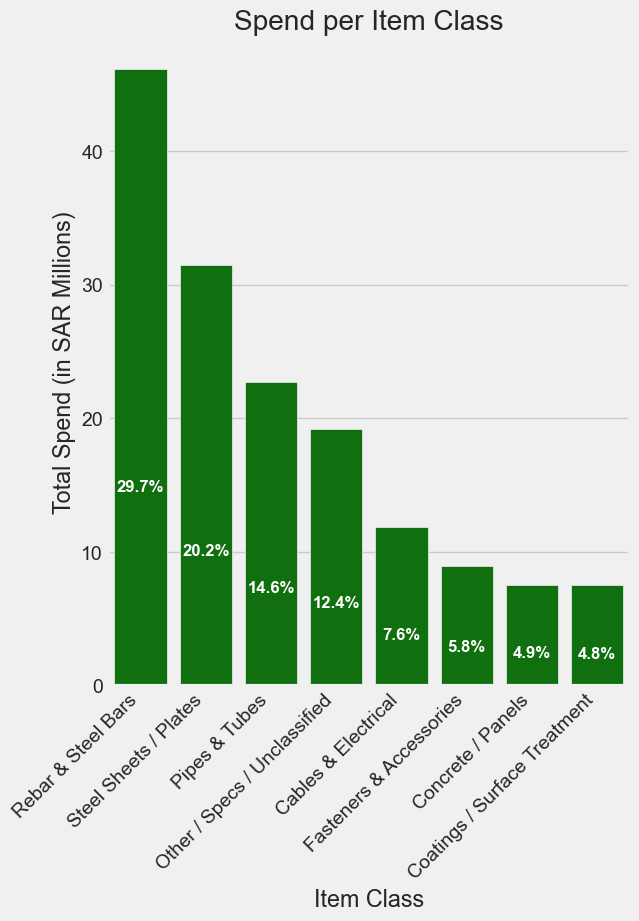

In [108]:
# Let us now plot the spendings for each class
# Since we have more than 5 classes, I believe a bar chart would be a better choice than others
import matplotlib.ticker as mtick


spendingsPerClass = df1.groupby('Embed_Class')['Total Bcy'].sum().sort_values(ascending=False) / 1000000 # Display them in Millions
spend_percent = (spendingsPerClass / spendingsPerClass.sum()) * 100

plt.figure(figsize=[6,8])
plot = sns.barplot(spendingsPerClass, color="green")
plt.title("Spend per Item Class")
plt.ylabel("Total Spend (in SAR Millions)")
plt.xlabel("Item Class")
plt.xticks(rotation=45, ha='right')
#plot.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')) # I want to write the spendings inside the bars
# Add % labels on bars
for i, v in enumerate(spend_percent.values):
    plot.text(i, v/2, f"{v:.1f}%", ha="center", va="center", color="white", fontweight="bold",fontsize=12)


plt.show() 

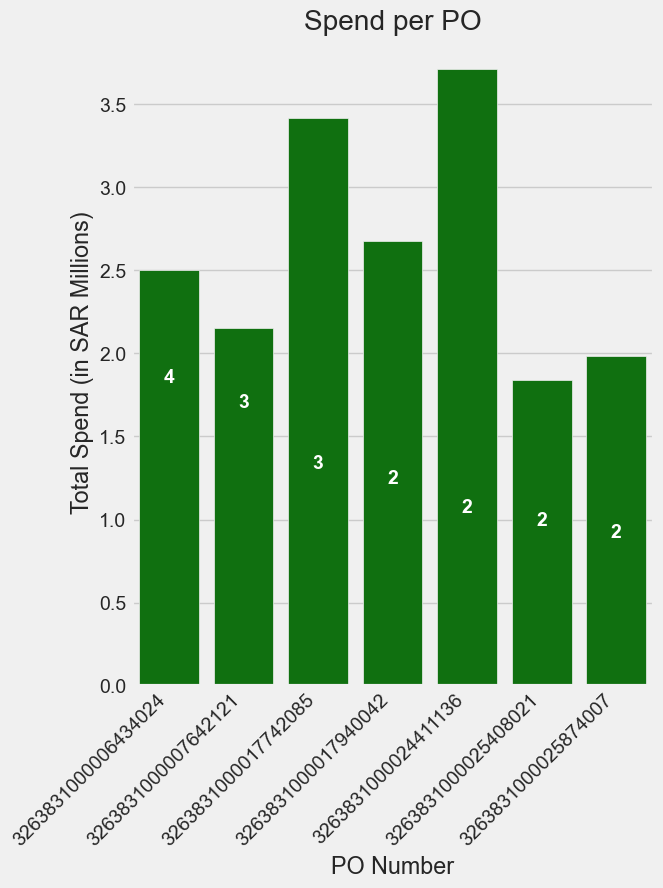

In [111]:
# Let us now plot the spendings for the top 10 POs
# Since we have more than 5 classes, I believe a bar chart would be a better choice than others
import matplotlib.ticker as mtick


spendingsPerClass = df1.groupby('Purchase Order ID')['Total Bcy'].sum().sort_values(ascending=False).nlargest(7) / 1000000 # Display them in Millions and take only take the top 7
plt.figure(figsize=[6,8])
plot = sns.barplot(spendingsPerClass, color="green")
plt.title("Spend per PO")
plt.ylabel("Total Spend (in SAR Millions)")
plt.xlabel("PO Number")
plt.xticks(rotation=45, ha='right')
#plot.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')) # I want to write the spendings inside the bars
for i, value in enumerate(spendingsPerClass.values):
    plot.text(
        i,                                # x position (bar index)
        value/2,                          # y position (middle of bar)
        f"{value:,.0f}",                  # formatted exact number with commas
        ha='center', va='center', color='white', fontweight='bold'
    )

plt.show() 

Embed_Class
Rebar & Steel Bars              19.808376
Other / Specs / Unclassified    19.633959
Steel Sheets / Plates           18.211844
Pipes & Tubes                   17.041284
Cables & Electrical             10.487915
Fasteners & Accessories          6.369484
Coatings / Surface Treatment     6.232325
Concrete / Panels                2.214813
Name: Quantity, dtype: float64


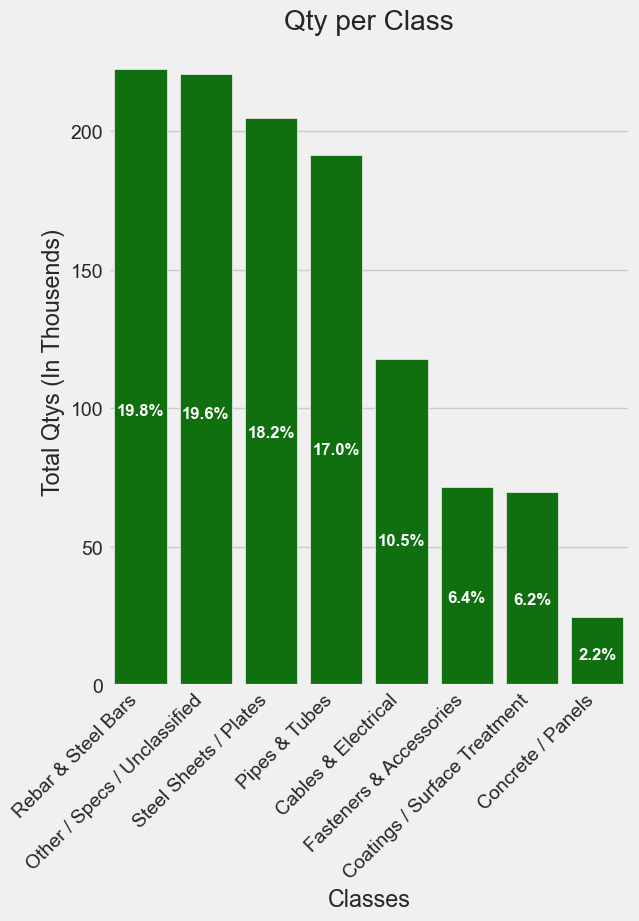

In [128]:
# Maybe we should take a look at the qtys per class

qtyPerClass = df1.groupby("Embed_Class")['Quantity'].sum().sort_values(ascending=False) / 1000 # Display Qtys of all classes in Thousands
qtyPercentage = (qtyPerClass / qtyPerClass.sum()) * 100 # Percentage of each qty
plt.figure(figsize=[6,8])
plot = sns.barplot(qtyPerClass, color="green")
plt.title("Qty per Class")
plt.ylabel("Total Qtys (In Thousends)")
plt.xlabel("Classes")
plt.xticks(rotation=45, ha='right')
print(qtyPercentage)
for i, v in enumerate(qtyPercentage.values):
    plot.text(i, v*5, f"{v:.1f}%", ha="center", va="center", color="white", fontweight="bold",fontsize=12) # I do not know why the 5 worked after many trials

plt.show()

# Results and Discussions


- From classes, we can see that 'Rebar & Steel Bars' and 'Steel Sheets / Plates' account for around 50% of the total spendings with a value around 77.5 M SAR. This suggests that these classes are critical spend drivers and have major impact on cost efficiency, supplier risk, and availability.
    - One thing that can be done in this case is to focus on is Strategic Sourcing / Negotiation, which means that we can explore negotiate bulk discounts or long-term framework contracts and supplier diversification for these 2. 
    - Altough these 2 categories seem important, maybe we can have some sort of demand study and analysis. For example, Are there over-specification like buying premium grade steel where standard suffices? is consumption aligned with actual operational needs? And so on
    - Also, we need to build a contingency plan in case of supplier disruptions

- I thought we would be able to find something from the PO analysis, but the first trial denied the need for further investigation. 

- As expected, the 2 classes with the highest spendings have the highest qtys out of all of the others. With the others also look simialr and in place

- <span style="color: yellow;">One additional thing that I want to test out before closing is the unit price, I will take it generally per line item just to see if there are additional room for imporvement</span>


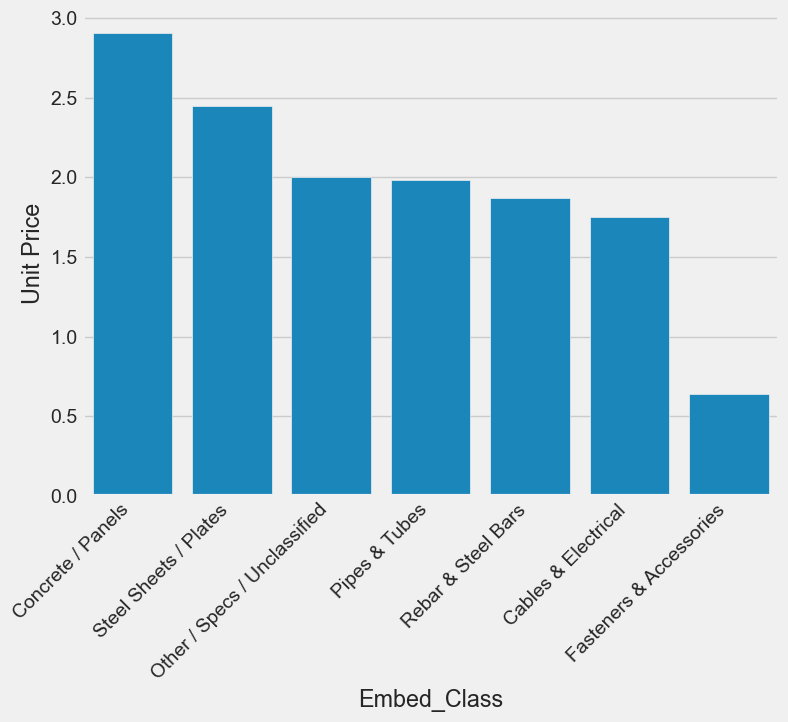

In [144]:
# Unit price
df1["Unit Price"] = df1["Total Bcy"] / df1["Quantity"] # Calculate the unit price
top = (df1.groupby("Embed_Class")["Unit Price"].sum() / 1000000).sort_values(ascending=False).nlargest(7) # Take top 10 to report them in Millions

plt.figure(figsize=[8,6])
sns.barplot(top)
plt.xticks(rotation=45, ha='right')
plt.show()

# Results and Discussions (Cont'd and Final)

- <span style="color: red;">Targeted workflow</span>
    * <span style="color: LightBlue;">Data Context Understanding</span> ✅
    * <span style="color: LightBlue;">Data Cleaning, Processing</span> ✅
    * <span style="color: LightBlue;">Data Analysis</span> ✅
    * <span style="color: LightBlue;">Results and Discussions</span> ✅
    * <span style="color: LightBlue;">Conclusion</span>

- Although this may not be the best way to obtain such info, it is worth noting here that "Steel Sheets / Plates" have such a high unit price, unlike the higher "Rebar & Steel Bars". This highly indicates the need for better negotiations and  sourcing for this one. While I'm sure the qtys, sizes and the type of materials play crucual role in determining the unit price, I'm sure that a huge potential saving can be achieved in such feature. 

# Conclusion

- <span style="color: red;">Targeted workflow</span>
    * <span style="color: LightBlue;">Data Context Understanding</span> ✅
    * <span style="color: LightBlue;">Data Cleaning, Processing</span> ✅
    * <span style="color: LightBlue;">Data Analysis</span> ✅
    * <span style="color: LightBlue;">Results and Discussions</span> ✅
    * <span style="color: LightBlue;">Conclusion</span> ✅

* We have come now to the end of the project. We have seen that real world data is very messy and need massive efforts in the processing and feature engineering stage to get competent and good results. 

- <span style="color: green;">Quick Wins</span>

Its evident that this is not the optimal way of approaching this project. However, I believe it is a strong prototype to showcase the potential if more time and resources exist. The embedding approach of the item name feature, which was the main source for categorization handled both languages effectively. Also, the initial manual classification excerise helped in shaping the path to formulate and create classes instead of coming up with new ones. 


- <span style="color: red;">Limitations and Mistakes</span>

It’s clear that the current approach has several limitations that would need to be addressed for a production-grade solution. The reliance on keyword lists and embeddings, while effective as a proof of concept, risks misclassification when descriptions are incomplete, overly technical, or inconsistent. The class definitions, although shaped through manual inspection, may not capture the full diversity of procurement items and could oversimplify categories. Additionally, the absence of integration with structured fields such as supplier, unit, or material codes means that valuable signals are left unused, which reduces accuracy. Finally, the thresholds and prompts for embeddings were defined heuristically rather than tuned with labeled data, making the system less robust to new or unseen cases. Also, one thing that I think I could have dealt with better is the rest of the features. I think I missed out on them and I should have either digged deeper to understand how they could be utilized or at least remove them! 

- <span style="color: LightBlue;">Recommendations for Future</span>

Looking ahead, the approach can be strengthened by incorporating more structured features alongside the text, such as supplier codes, material groups, and unit measures, to reduce dependency on item names alone. A supervised learning pipeline with a labeled dataset would allow for systematic evaluation and tuning of thresholds, improving both accuracy and consistency. Expanding the taxonomy of categories through consultation with domain experts can ensure better coverage and alignment with business needs. Finally, deploying the solution within an interactive dashboard that allows continuous feedback and correction from end users would create a feedback loop, ensuring the model adapts to new data and evolves into a more reliable system over time.

- <span style="color: red;">Targeted workflow</span>
    * <span style="color: LightBlue;">Data Context Understanding</span> ✅
    * <span style="color: LightBlue;">Data Cleaning, Processing</span> ✅
    * <span style="color: LightBlue;">Data Analysis</span> ✅
    * <span style="color: LightBlue;">Results and Discussions</span> ✅
    * <span style="color: LightBlue;">Conclusion</span> ✅

    ✅✅✅✅✅
